# Mitigating multiqubit gate noise
In this notebook, we show how to use the ``ZeroNoiseExtrapolator`` plugin to mitigate multiqubit gate noise by means of an extrapolation to the zero noise regime.

The idea is to measure the observable of interest $\hat{O}$ under varying noise intensities, so that a noise-free value can be inferred. The noise is artificially increased by multiplying the number of $CNOT$ gates: since $CNOT^2=I$, one can replace each $CNOT$ gate in the circuit by a number $2n_{\mathrm{pairs}}+1$ of identical $CNOT$ gates without changing the logical function of the circuit. Since the two-qubit gates are considerably more faulty than the one-qubit gates, this boils down to globally increasing the noise that will be picked at the execution of the circuit: one can show that as a first approximation, considering the gate noise can be modelled by a depolarizing channel, the equivalent noise level will correspond to a $(2n_{\mathrm{pairs}}+1)$-fold increase of the original noise level (see [Hybrid quantum-classical algorithms and quantum error mitigation by endo et al.](https://arxiv.org/abs/2011.01382) p.23 for the detailed calculation).

By choosing a fit $f$ so that $\langle \hat{O} \rangle_{\mathrm{noisy}} = f(n_\mathrm{pairs})$, one can thus estimate the noise-free expectation value of the observable as $\langle \hat{O} \rangle_{\mathrm{noise-free, inferred}}  = f(-0.5)$.

The plugin allows for either a linear fit (Richardson extrapolation)

$f(n_\mathrm{pairs}) = an_\mathrm{pairs} + b$

or an exponential one

$f(n_\mathrm{pairs}) = \pm e^{an_\mathrm{pairs}+b} + C$.

**Note**: The plugin allows to increase the noise level with a gate that is different from the $CNOT$ gate. This corresponds to the more general "unitary-folding" technique, in which we replace each occurence of $G$ by $G(GG^{\dagger})^n$. See for example [Digital zero noise extrapolation for quantum error mitigation
 by Giurgica-Tiron et al.](https://arxiv.org/abs/2005.10921)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qat.fermion.circuits import make_shallow_circ
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.transforms import transform_to_jw_basis

from qat.hardware import DefaultHardwareModel, make_depolarizing_hardware_model

from qat.plugins import ZeroNoiseExtrapolator

from qat.qpus import LinAlg, NoisyQProc

We first define some circuit, and an observable (namely an embedded impurity Hamiltonian) to be measured upon it. 

In the following example, the circuit is some instance of a small hardware-efficient circuit on four qubits that was found to be able to prepare one-impurity models' ground states. Such a circuit instance may be encountered in a VQE optimization procedure for example, and we'd like to obtain an accurate evaluation of the energy attached to it.

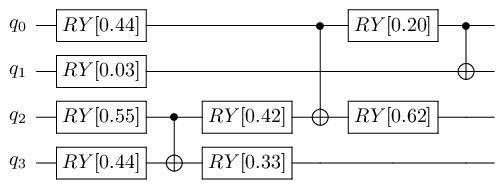

In [2]:
# create circuit
np.random.seed(2)
theta = np.random.random(8)
circ = make_shallow_circ()
bd_circ = circ.bind_variables({r"\theta_{%i}" % i: theta[i] for i in range(8)})

bd_circ.display()

The observable may be the expected energy of a one-impurity Hamiltonian:

In [3]:
# create job (measure energy)
U = 1
mu = U / 2
D = -0.4 * np.eye(2)
lambd_c = 0.1 * np.eye(2)
nbqbits = 4

hamilt = make_embedded_model(U, mu, D, lambd_c, grouping="spins")

obs = transform_to_jw_basis(hamilt)
job = bd_circ.to_job(observable=obs)

We evaluate it on the perfect QPU:

In [4]:
perfect_qpu = LinAlg()
perfect_res = perfect_qpu.submit(job)
E_noisefree = perfect_res.value
print("E without noise=", E_noisefree)

E without noise= -0.0687711899363205


Now, we define a depolarizing QPU, and evaluate the energy with it.

In [5]:
eps1 = 0.0016
eps2 = 0.006
hw_model = make_depolarizing_hardware_model(eps1=eps1, eps2=eps2, depol_type="randomizing", correl_type="multi_qubit")
noisy_qpu = NoisyQProc(hardware_model=hw_model, sim_method="deterministic-vectorized")
noisy_res = noisy_qpu.submit(job)
E_noisy = noisy_res.value
print("E noisy=", E_noisy, "(error: %s %%)" % (abs(E_noisefree - E_noisy) / abs(E_noisefree) * 100))

E noisy= -0.0712308546210251 (error: 3.5765917195589525 %)


The ZNE plugin will provide a better estimate. It will evaluate the energy associated to circuits that are similar to the input circuit, but in which pairs of $CNOT$ gates were inserted, so that the noise is artifically increased without impacting the logical function of the circuit (as $CNOT^2=I$).

One must set the number of fitting points it will use, as well as the form of the fit, which can be either linear or exponential. Usually, the linear 'fit' on two points is good enough. We'll take a look at the form of the plot $E=f(n_{\mathrm{pairs}})$ later.

In [6]:
# create error mitigating stacks
ZNE_stack = ZeroNoiseExtrapolator(n_ins=1) | noisy_qpu
ZNE_res = ZNE_stack.submit(job)
E_mitigated_linear = ZNE_res.value
print(
    "E mitigated with linear ansatz:",
    E_mitigated_linear,
    "(error: %s %%)" % (abs(E_noisefree - E_mitigated_linear) / abs(E_noisefree) * 100),
)

a = ZNE_res.meta_data["ZNE_fit_parameters"]["a"]
b = ZNE_res.meta_data["ZNE_fit_parameters"]["b"]

linear_fit = [a * x + b for x in range(-1, 100)]

E mitigated with linear ansatz: -0.06973561805117424 (error: 1.402372295356187 %)


It is more accurate! 

Now, let's see how the energy depends on the number of $CNOT$ pairs insertions in our model. For a global depolarizing noise with noise intensity $\varepsilon$, one can show that at first order

$ \langle \hat{H} \rangle_{\mathrm{noisy}} = (1-\varepsilon)\langle \hat{H} \rangle_{\mathrm{noise-free}} + \varepsilon \frac{\mathrm{Tr}(\hat{H})}{2^{n_{\mathrm{qbits}}}}$

We'll look at the evolution of the energy with the number of insertions by using the ZNE plugin with a large number of maximum CNOT pairs insertions and getting the fitting values from the result's meta data.

In [7]:
ZNE_stack = ZeroNoiseExtrapolator(n_ins=100) | noisy_qpu  # trick to compute the noisier and noisier expectation values of obs
ZNE_res = ZNE_stack.submit(job)
energies = ZNE_res.meta_data["values_for_ZNE"]

Text(0, 0.5, 'energy')

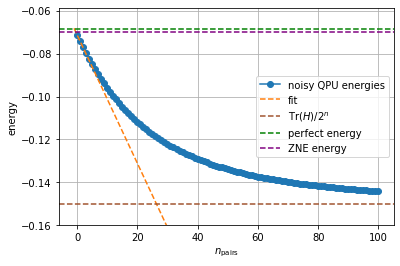

In [8]:
plt.plot(range(101), energies, marker="o", label="noisy QPU energies")
plt.plot(range(-1, 100), linear_fit, ls="dashed", label="fit")
plt.axhline(obs.constant_coeff, ls="dashed", color="sienna", label="$\mathrm{Tr}(H)/2^n$")
plt.axhline(E_noisefree, ls="dashed", color="green", label="perfect energy")
plt.axhline(E_mitigated_linear, ls="dashed", color="purple", label="ZNE energy")
plt.grid()
plt.legend()
plt.ylim(ymin=obs.constant_coeff - 0.01, ymax=perfect_res.value + 0.01)
plt.xlabel("$n_{\mathrm{pairs}}$")
plt.ylabel("energy")

Now, we turn to an exponential fit as clearly, the curve exhibits an exponential decay. We still limit ourselves to a two-point fit to avoid multiplying the number of circuit evaluations.

In [9]:
ZNE_stack = ZeroNoiseExtrapolator(n_ins=1, extrap_method="exponential") | noisy_qpu
ZNE_res = ZNE_stack.submit(job)
E_mitigated_exponential = ZNE_res.value
print(
    "E mitigated with exponential ansatz:",
    E_mitigated_exponential,
    "(error: %s %%)" % (abs(E_noisefree - E_mitigated_exponential) / abs(E_noisefree) * 100),
)

a = ZNE_res.meta_data["ZNE_fit_parameters"]["a"]
b = ZNE_res.meta_data["ZNE_fit_parameters"]["b"]

exp_fit = [np.exp(a * x + b) + obs.constant_coeff for x in range(-1, 100)]
# be careful with the sign before the exponential, it depends on the job!

E mitigated with exponential ansatz: -0.06969164972466223 (error: 1.3384380715151714 %)


It is slightly better. Let's look at the fit:

Text(0, 0.5, 'energy')

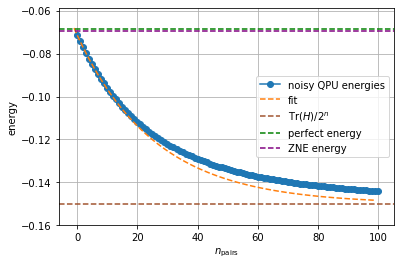

In [10]:
plt.plot(energies, marker="o", label="noisy QPU energies")
plt.plot(range(-1, 100), exp_fit, ls="dashed", label="fit")
plt.axhline(obs.constant_coeff, ls="dashed", color="sienna", label="$\mathrm{Tr}(H)/2^n$")
plt.axhline(E_noisefree, ls="dashed", color="green", label="perfect energy")
plt.axhline(E_mitigated_exponential, ls="dashed", color="purple", label="ZNE energy")
plt.grid()
plt.legend()
plt.ylim(ymin=obs.constant_coeff - 0.01, ymax=perfect_res.value + 0.01)
plt.xlabel("$n_{\mathrm{pairs}}$")
plt.ylabel("energy")

Finally, one can wonder if we could have obtained a sensitively better estimate by making a fit on more noise-inflated points. Let's try up to 10 insertions of the decomposition of the identity:

In [11]:
# trying more points
exp_mitigated_values = [E_mitigated_exponential]

for i in range(2, 11):
    ZNE_stack = ZeroNoiseExtrapolator(n_ins=i, extrap_method="exponential") | noisy_qpu
    ZNE_res = ZNE_stack.submit(job)
    exp_mitigated_values.append(ZNE_res.value)

error = [abs(E_noisefree - E_mit) / abs(E_noisefree) * 100 for E_mit in exp_mitigated_values]

Text(0, 0.5, 'error (%)')

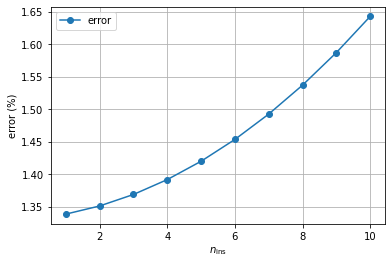

In [12]:
plt.plot(range(1, 11), error, marker="o", label="error")
plt.grid()
plt.legend()
plt.xlabel("$n_{\mathrm{ins}}$")
plt.ylabel("error (%)")

Not only do the results do not improve but the error even increases a little, so, no need to bother extrapolating on a lot of points!